#  Case study: Digital logic circuits in yeast with CRISPR-dCas9 NOR gates

This Jupyter notebook is used for a case study of [an article](https://www.nature.com/articles/ncomms15459?fbclid=IwAR3QN3lGy5qcakL6c9YztTK2aCRDt2xNNgvGr4DEvkVc4gzT6aV1TaBubF0) published by Gander et al. in *Nature Communications*.

This case study was written by Hieu Do, Jonathan Mah, and Zachary McNulty as part of the final project for Amath 422. All student authors contributed equally to this work.

In [0]:

!pip install tellurium

    100% |████████████████████████████████| 112kB 4.6MB/s 
    100% |████████████████████████████████| 4.3MB 6.5MB/s 
    100% |████████████████████████████████| 3.6MB 10.8MB/s 
    100% |████████████████████████████████| 4.1MB 1.2MB/s 
    100% |████████████████████████████████| 37.8MB 644kB/s 
    100% |████████████████████████████████| 34.6MB 1.3MB/s 
    100% |████████████████████████████████| 5.3MB 7.5MB/s 
    100% |████████████████████████████████| 3.3MB 1.2MB/s 
    100% |████████████████████████████████| 4.6MB 7.7MB/s 
    100% |████████████████████████████████| 5.8MB 4.2MB/s 
  Running setup.py bdist_wheel for retrying ... - done
  Stored in directory: /root/.cache/pip/wheels/d7/a9/33/acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c
Successfully built retrying
  Found existing installation: plotly 1.12.12
    Uninstalling plotly-1.12.12:
      Successfully uninstalled plotly-1.12.12


In [0]:
import tellurium as te
import time
import numpy as np
import matplotlib.pyplot as plt

# Tellurium Example and References
The following section is an example of the syntax used in the Tellurium python package, which we used for numerical integration.

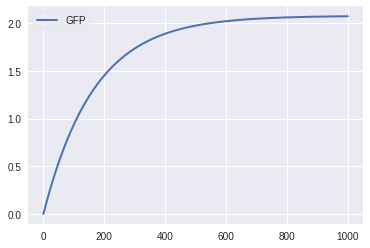

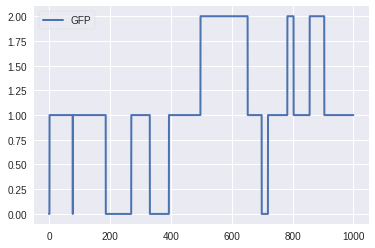

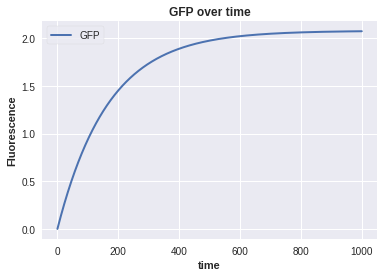

In [0]:
# 

# NOT GATE MODEL (as described in paper)
# Parameters taken from supplementary section of paper
# Those that varied between different types of gRNA were simply averaged

# Tellurium is a software package for performing numerical integration on the systems
# of differential equations found within chemical/molecular interactions. You can
# read more about it in the documentation:
# https://tellurium.readthedocs.io/en/latest/
# or here:
# https://media.readthedocs.org/pdf/tellurium/param-est/tellurium.pdf

# NOTE: these text models such as the not gate model below are written in a format
#       called Antimony, which tellurium can interpret and perform all the necessary
#       numerical integration steps on. To read more about this format, check out:
#       https://tellurium.readthedocs.io/en/latest/antimony.html

not_gate = """

model NOT_gate()

  species INPUT1, OUTPUT;

  OUTPUT => ; b * OUTPUT
  $dummy => OUTPUT ; b * (  (v_d*(1 - L)) / (1 + (INPUT1 / k_d)^n) + L*v_d)


  // Species Initializations
  INPUT1 = 0;
  OUTPUT = 0;

  // Parameter Initializations
  b = 0.006;
  v_d = 20;
  L = 0.1;
  k_d = 8.75;
  n = 2.231;

end

"""


# Since models are just strings, we can expand upon them with just string operations!
# check out submodels and specifically the "is" keyword which can identify two species names as the same
# This linkes the first gate to the circuits initial INPUT

full_model = not_gate + """

model cascade()

  // constant INPUT (change this later)
  initial_INPUT = 100;
  
  // create a single NOT gate submodel
  initial_input -> ; initial_input
  
  G1 : NOT_gate()
  G1.INPUT1 is initial_INPUT
"""

# We can now load this model into tellurium and simulate it; te.loada(string) loads an antimony model and converts it to 
# a roadrunner instance (i.e. a model we can simulate)

model = te.loada(full_model + "G1.OUTPUT is GFP \n end")

model.simulate(0,1000,10000, selections=['time', 'GFP'])  # simualate(startTime,stopTime, number_points)
model.plot()               # plot results

# we can also do stochastic simulations using the gillespie integrator
model.reset()
model.gillespie(0,1000,10000, selections=['time', 'GFP'])
model.plot()

# selecting only certain species to be plotted/simulated can be done with selections keyword
model.reset()
model.simulate(0,1000,10000, selections=['time', 'GFP'])

# .plot() accepts most of the same keywords as MATLABs or matplotlibs plotting functions
model.plot(title = "GFP over time", ytitle="Fluorescence", xtitle="time")

# Recreating Figure in Paper
The figure we chose to recreate was [figure 4a](https://www.nature.com/articles/ncomms15459/figures/4) from the original study by Gander et al. Note that the original study uses arbitrary units of fluorescence. We have also used arbitrary units of fluorescence, but have scaled down for readability.


Red Lines separate ON and OFF signals


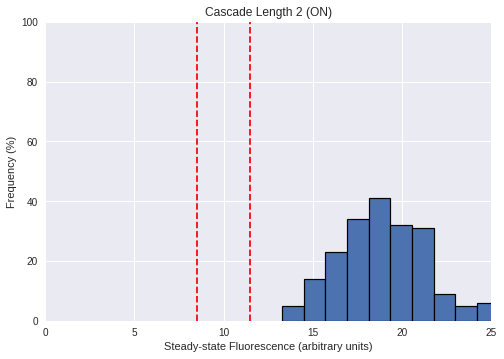

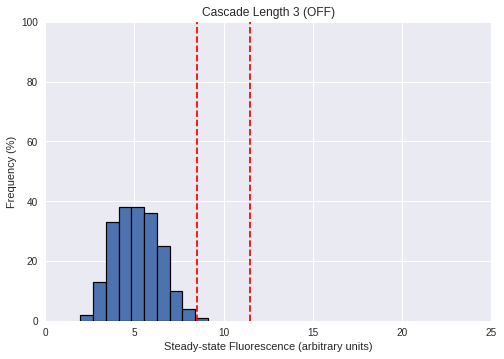

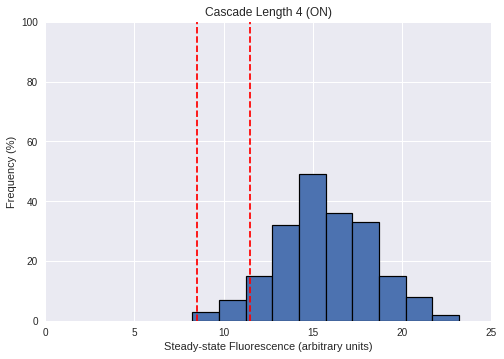

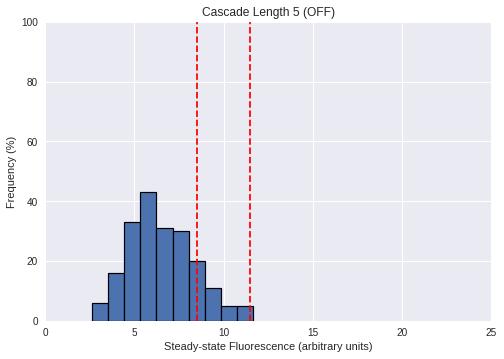

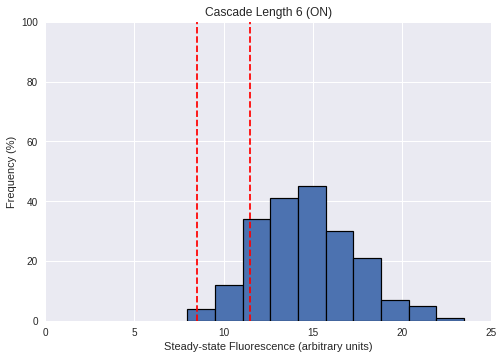

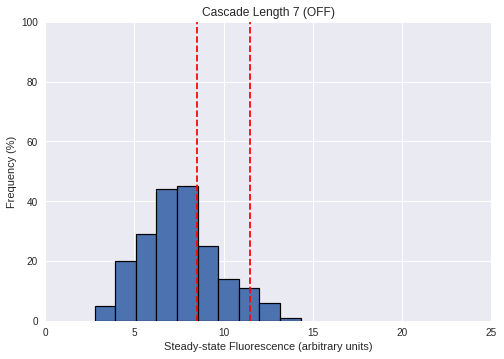

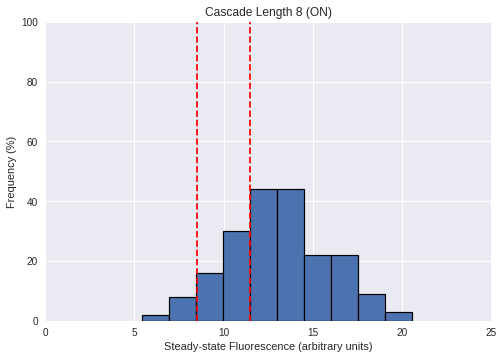

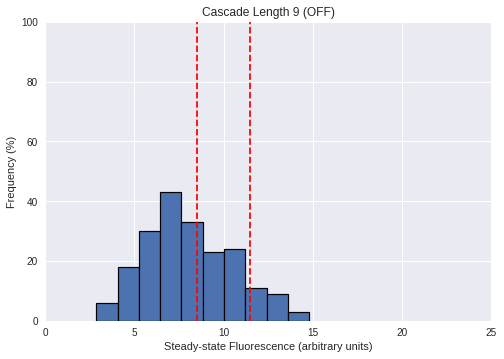

In [0]:
# Since models are just strings, we can expand upon them with just string operations!
# These text models 
# check out submodels and specifically the "is" keyword which can identify two species names as the same
# This linkes the first gate to the circuits initial INPUT

full_model = not_gate + """

model cascade()

  // constant INPUT (change this later)
  initial_INPUT = 100;
  
  G1 : NOT_gate()
  G1.INPUT1 is initial_INPUT
"""

# Now that we have the single NOT_gate model, we can chain a bunch of them together 
# and link their species (see submodels in Tellurium - Antimony Reference)

max_cascade_length = 9
trials = 200
print("Red Lines separate ON and OFF signals")

# for each cascade length
for i in range(2, max_cascade_length + 1):
  full_model += "\n  G" + str(i) + " : NOT_gate() \n"
  full_model += "  G" + str(i) + ".INPUT1 is G" + str(i-1) + ".OUTPUT \n"
  
  model = te.loada(full_model + "G" + str(i) + ".OUTPUT is GFP \n end")
  
  model.L =  5;
  
  steady_state_means = []
  for _ in range(trials):
    # reset simulation; set all concentrations back to initial conditions
    model.reset()

    # stochastic simulations
    results = model.gillespie(0,5000,10000, selections = ['time', "GFP"])
    #model.plot(title = "Cascade Length " + str(i), xtitle = "Time (s)", ytitle = "Fluorescence", ylim=[0,50])
 
    
    # approximate steady state; average last 2000 timepoints of GFP
    # Results is a Named Array, so we can access time series data as we access values
    # in a dictionary, using the species name as the key
    mean = np.mean(results["GFP"][-2000:])
    steady_state_means.append(mean)
 
  plt.hist(steady_state_means, edgecolor='black', linewidth=1.2)
  
  plt.title("Cascade Length " + str(i) + " (" + str("ON" if i % 2 == 0 else "OFF") + ")")
  plt.xlim([0,25])
  plt.ylim([0,0.5* trials])
  plt.xlabel("Steady-state Fluorescence (arbitrary units)")
  plt.ylabel("Frequency (%)")
  
  # plot vertical lines to differentiate between clearly on and clearly off
  plt.plot([8.5, 8.5], [0, 100], 'r--')
  plt.plot([11.5, 11.5], [0, 100], 'r--')
  
  plt.show()

In [0]:
print(full_model)



model NOT_gate()

  species INPUT1, OUTPUT;

  OUTPUT => ; b * OUTPUT
  $dummy => OUTPUT ; b * (  (v_d*(1 - L)) / (1 + (INPUT1 / k_d)^n) + L*v_d)


  // Species Initializations
  INPUT1 = 0;
  OUTPUT = 0;

  // Parameter Initializations
  b = 0.006;
  v_d = 20;
  L = 0.1;
  k_d = 8.75;
  n = 2.231;

end



model cascade()

  // constant INPUT (change this later)
  initial_INPUT = 100;
  
  G1 : NOT_gate()
  G1.INPUT1 is initial_INPUT

  G2 : NOT_gate() 
  G2.INPUT1 is G1.OUTPUT 

  G3 : NOT_gate() 
  G3.INPUT1 is G2.OUTPUT 

  G4 : NOT_gate() 
  G4.INPUT1 is G3.OUTPUT 

  G5 : NOT_gate() 
  G5.INPUT1 is G4.OUTPUT 

  G6 : NOT_gate() 
  G6.INPUT1 is G5.OUTPUT 

  G7 : NOT_gate() 
  G7.INPUT1 is G6.OUTPUT 

  G8 : NOT_gate() 
  G8.INPUT1 is G7.OUTPUT 

  G9 : NOT_gate() 
  G9.INPUT1 is G8.OUTPUT 



# Parameter Sensitivity Analysis

Below, we have code that sweeps through the parameters of our model and adjust their values along a given range. Then, we plot the resulting steady states to see how this change affects our system and give insight into what parameters significantly affect the ability of our system to differentiate between ON and OFF states. In an ideal system, the ON states (the output of the even-numbered gates) produce significantly more fluorescence than the OFF states (the output of odd-numbered gates). Therefore, we will look for parameter values that maximize this difference and compare this to the performance of the original parameter value.



ON States are represented by solid lines while OFF states are drawn with dashed lines





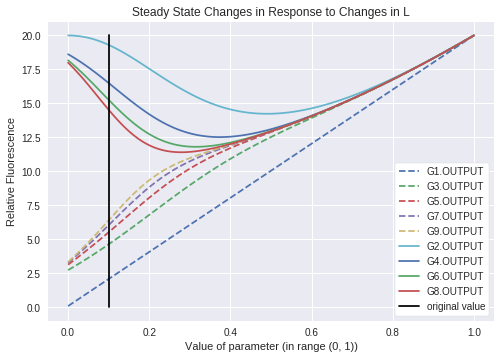

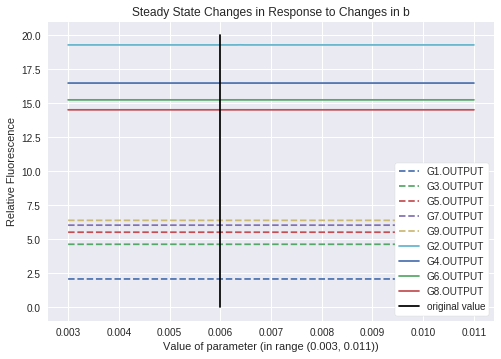

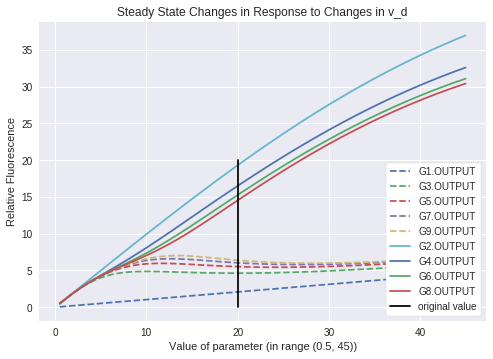

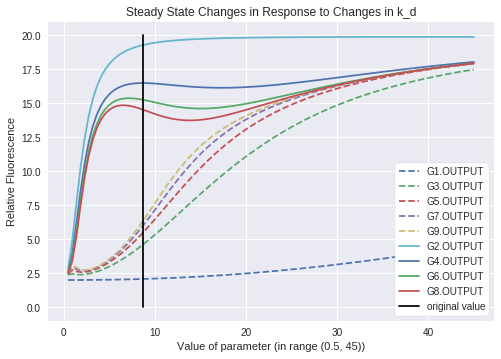

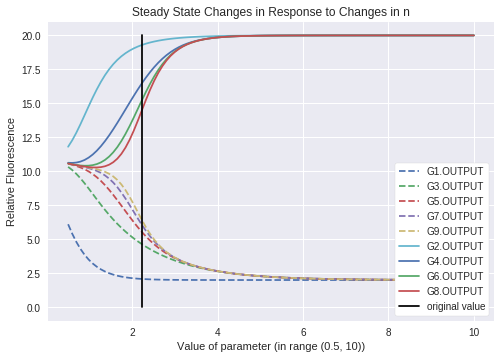

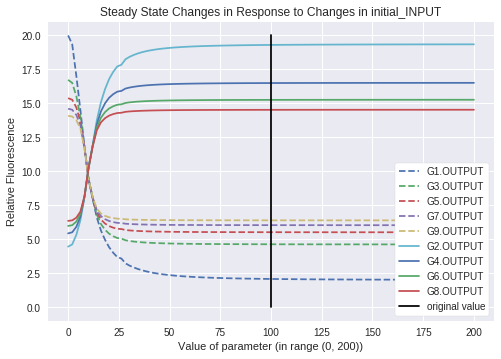

In [0]:
NOT_cascade = full_model + "\n\nG" + str(max_cascade_length) + ".OUTPUT is GFP\nend"
#print(NOT_cascade)

not_model = te.loada(NOT_cascade)


# original parameter values
#  b = 0.006;
#  v_d = 20;
#  L = 0.1;
#  k_d = 8.75;
#  n = 2.231;

# parameters of our system that we want to do sweep over
parameters = ['L' , 'b', 'v_d', 'k_d', 'n', "initial_INPUT"]
original_values = [0.1, 0.006, 20, 8.75, 2.231, 100]

# ranges across what we want to do the sweep for each corresponding parameter
# For example, the first tuple (0,1) says to do a sweep over values of the first
# parameter in the list above, L, between 0 and 1.
# Ranges taken from corresponding paper
param_ranges = [(0,1), (0.003, 0.011), (0.5,45), (0.5,45), (0.5,10), (0, 200)] 

# number of points within the param_range above ^ to take (i.e. resolution of plots below)
num_points = 100


print("\n\nON States are represented by solid lines while OFF states are drawn with dashed lines\n\n\n")

# NOTE that only a single parameter is varied at a time. All other parameters are
# left at 
for i, param in enumerate(parameters):
  values = np.linspace(param_ranges[i][0], param_ranges[i][1], num_points)
  results = None
  names = list([])
  
  for val in values:
    # reset parameter values to original values when model was first loaded
    not_model.resetToOrigin()
    
    if param == 'initial_INPUT':
      exec("not_model.initial_INPUT = %f" % val)
    else:
    
      # set parameters for each gate to the given value
      for gate_num in range(1, max_cascade_length + 1):
        perterb = "G" + str(gate_num) + "_" + param

        # exec just executes a string as if it was a line of code
        # Here, for example, it is as if the line read:
        # not_model.<param being changed> = val
        exec("not_model." + perterb + "= %f" % val) 


    # calculate system steady states
    steady_states = not_model.getSteadyStateValues()
    
    # collect steady state values of each species for each value of the parameter
    if results is None:
      results = steady_states
    else:
      results = np.vstack((results, steady_states))
 
  
  # Plot stuff!
  plt.plot(values, results[:, 1::2], "--")  # OFF STATES
  plt.plot(values, results[:, 2::2], "-") # ON STATES
  plt.plot([original_values[i], original_values[i]], [0,20], 'k-')
  plt.legend(["G" + str(i) + ".OUTPUT" for i in range(1, max_cascade_length+1,2)] + ["G" + str(i) + 
                             ".OUTPUT" for i in range(2, max_cascade_length+1,2)] + ["original value"], frameon=True, facecolor=[1,1,1], framealpha=1, loc='lower right')
  plt.title("Steady State Changes in Response to Changes in " + param)
  plt.ylabel("Relative Fluorescence")
  plt.xlabel("Value of parameter (in range " + str(param_ranges[i]) + ")")
  plt.show()
    
  
  

  Above, we can see that there are some parameters we might be able to alter to improve the performance of the system (make on and off signals more different/differentiable).

*   Decreasing the Leak rate $L$ improves the performance of our system
*   Increasing the maximum transcription rate $v_d$ improves the performance of our system
*   Increasing the cooperativity of our repressor system $n$ improves the performance of our system
*   Increasing the strength of repression (decreasing $k_d$) improves the performance of our system
*   As long as the input is above a certain threshold, it has no effect on the performance of our system. 
However, this threshold may become an issue in responding to low levels of stimuli.












  While it seems our current parameter set provides a fairly reliable difference between the on and off states at steady state, it appears that the signals are converging: as we increase the number of gates the output of ON steady state approaches the OFF steady state. This suggest that if we want to expand the size of our system for future models, we will have to make some improvements in some of these parameter values.

## Building the NOR gate model

To extend the Mathematical model we have currently to a NOR gate, all we have to do is introduce a second input at each gate. The only aspect of our system this will change is the transcription rate.


In [0]:
nor_gate = """

model NOR_gate()

  species INPUT1, INPUT2, OUTPUT;


  OUTPUT => ; b * OUTPUT
  $dummy => OUTPUT ; b * ( (v_d * (1 - L)) / (1 + (INPUT1 / k_d)^n + (INPUT2 / k_d)^n) + L*v_d)


  // Species Initializations
  INPUT1 = 0;
  INPUT2 = 0;
  OUTPUT = 0;

  // Parameter Initializations
  b = 0.006;
  v_d = 20;
  L = 0.06;
  k_d = 8.75;
  n = 2.231;

end

"""

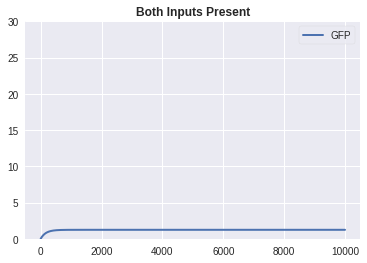

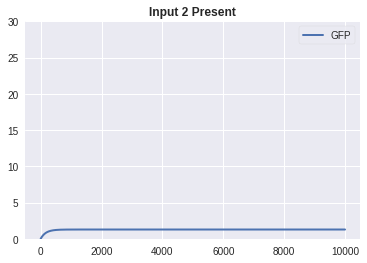

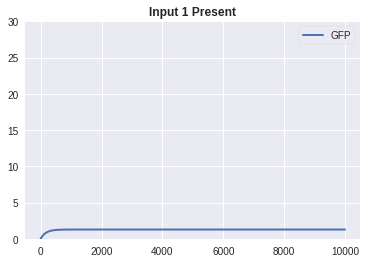

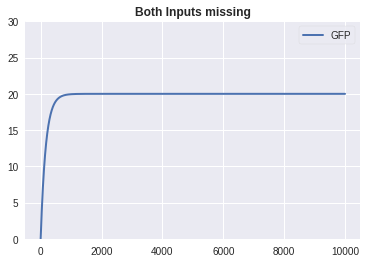

In [0]:
full_model = nor_gate + """

model cascade()

  // constant INPUT (change this later)
  INPUT1 = 100;
  INPUT2 = 100;
  
  G1 : NOR_gate()
  G1.INPUT1 is INPUT1
  G1.INPUT2 is INPUT2
"""

### Testing NOR gate
model = te.loada(full_model + "\nG1.OUTPUT is GFP\nend")

def check_logic_table(model):
  """
  Given a roadrunner model of a two initial input system, this method will
  generate plots for all possible combinations of the activity of these two inputs
  (i.e. generate a truth table for a given logic gate)
  """
  
  selections = ["time", "GFP"]#"INPUT1", "INPUT2", "GFP"]
  
  ## Both inputs present
  model.simulate(0,10000,10000, selections = selections)
  model.INPUT1 = 100
  model.INPUT2 = 100
  model.plot(title="Both Inputs Present", ylim=[0,30])

  ## INPUT 1 missing
  # we can change a parameter/initial condition by directly
  # refering to it within the model
  model.reset()
  model.INPUT1 = 0
  model.INPUT2 = 100
  model.simulate(0,10000,10000, selections = selections)
  model.plot(title="Input 2 Present", ylim=[0,30])

  ## INPUT 2 missing
  # resetToOrigin() returns parameter values to the values when the model
  # was first loaded
  model.resetToOrigin()
  model.INPUT2 = 0
  model.INPUT1 = 100
  model.simulate(0,10000,10000, selections = selections)
  model.plot(title="Input 1 Present", ylim=[0,30])

  ## BOTH inputs missing
  model.resetToOrigin()
  model.INPUT1 = 0
  model.INPUT2 = 0
  model.simulate(0,10000,10000, selections = selections)
  model.plot(title="Both Inputs missing", ylim=[0,30])


check_logic_table(model)

## Analyzing NOR Gate Functionality and Building New Gates
Now that we have the basic NOR gate functioning, we can try to build more complicated circuits. Let's start by building a few other types of gates and verifying that they produce the proper truth tables. Once we have verified this, we will be confident we can accurately construct more complicated circuits from this simple nor gate model. For simplicity, we will avoid using stochastic simulations until later.

In [0]:
def add_connections(incomplete_model, connections_to_add, gate_types):
  """
  Takes an incomplete model (in the form of a string) and a dictionary of connections to add
  of the form {Gene number regulated : [gene number of regulator 1, gene number of regulator 2]}.
  Given this list of regulators for each gene it can build the proper network. 
  Use -1 and -2 as flags to signal that initial_input1 and initial_input2 are the
  regulators respectively. Note that only providing a single connection (i.e. {1 : 2})
  will leave one of the INPUTS are zero, as they are initialized in the NOR gate model
  
  params
  
  incomplete_model = antimony string to append these connections to
  connections_to_add = dictionary of {gene number : [regulating gene number 1 [, regulating gene number 2] ]}
                       you can also directly specify the regulator (i.e. in the case that the regulator is
                       an initial input and not the product of some gene) -> {gene number : [gene number, "regulator name"]}
  gate_types = dictionary {gene number : gate type as a string in all CAPS} -> {1: "NOR", 2:"NOT"}
                states that gate 1 is a NOR gate and gate 2 is a NOT gate
  """
  
  for key in connections_to_add:
    gene = "G" + str(key)
    incomplete_model += "\n\n" + gene + " : " + gate_types[key] + "_gate()\n"
    
    if len(connections_to_add[key]) > 2:
      raise ValueError("A NOR gate may have at most two inputs!")
    
    for i, regulator in enumerate(connections_to_add[key]):
      if type(regulator) == int:
        regulator = "G" + str(regulator) + ".OUTPUT"
   
      incomplete_model += gene + ".INPUT" + str(i + 1) + " is " + regulator + "\n"
  
  return incomplete_model     

In [0]:
incomplete_model = nor_gate + """

model cascade()

  // constant INPUT (change this later)
  INPUT1 = 100;
  INPUT2 = 100;

"""

The schematics for the construction of these gates from NOR gates were found in the paper that inspired this project. See this paper for more details (linked at top). Gene numbers are assigned arbitrarily.

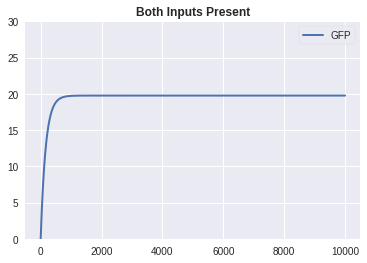

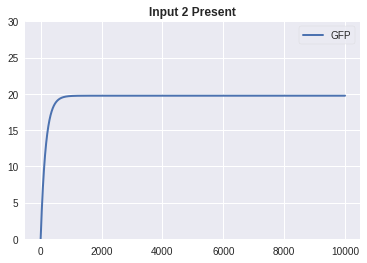

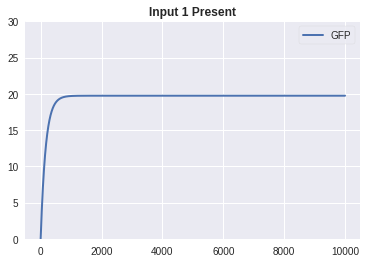

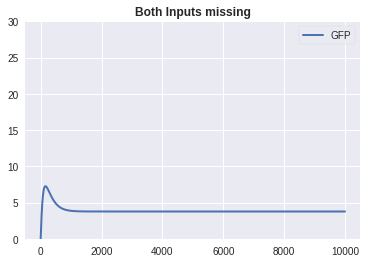

In [0]:
# OR GATE

connections_to_add = {1:["INPUT1","INPUT2"], 2:[1]}
gate_types = {1:"NOR", 2:"NOR"}
 
OR_gate = add_connections("", connections_to_add, gate_types)
full_model = incomplete_model + OR_gate + "\n\nG2.OUTPUT is GFP \nend"

model = te.loada(full_model)
check_logic_table(model)

or_gate = "model OR_gate()\n\nspecies INPUT1, INPUT2, OUTPUT \n\n" + OR_gate + "\n G2.OUTPUT is OUTPUT\nend"

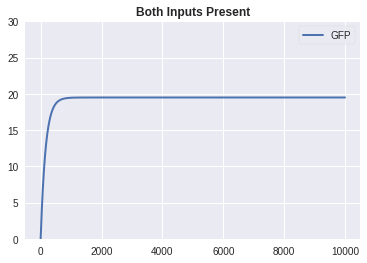

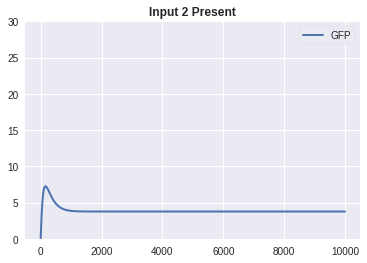

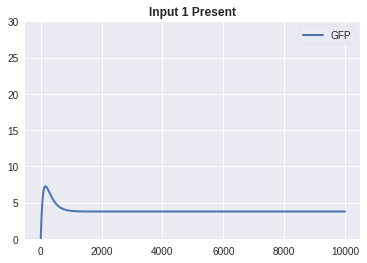

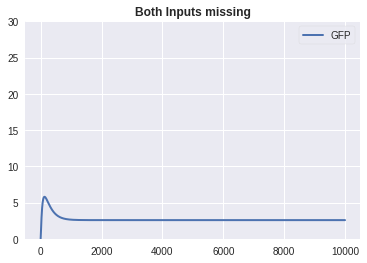

In [0]:
# AND GATE

connections_to_add = {1:["INPUT1"], 2:["INPUT2"], 3:[1,2]}
gate_types = {1:"NOR", 2:"NOR", 3:"NOR"}

AND_gate = add_connections("", connections_to_add, gate_types)
full_model = incomplete_model + AND_gate + "\n\nG3.OUTPUT is GFP \nend"

model = te.loada(full_model)
check_logic_table(model)

and_gate = "model AND_gate()\n\nspecies INPUT1, INPUT2, OUTPUT \n\n" + AND_gate + "G3.OUTPUT is OUTPUT\nend"

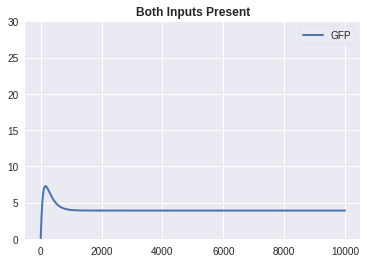

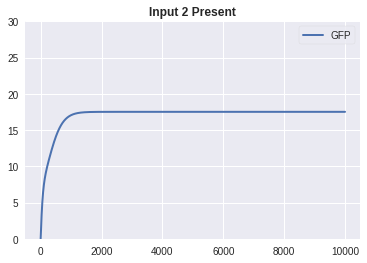

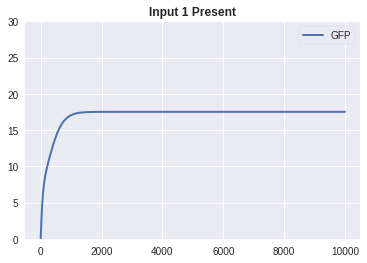

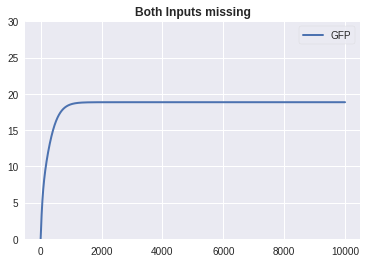

In [0]:
# NAND GATE

connections_to_add = {1:["INPUT1"], 2:["INPUT2"], 3:[1,2], 4:[3]}
gate_types = {1:"NOR", 2:"NOR", 3:"NOR", 4:"NOR"}

NAND_gate = add_connections("", connections_to_add, gate_types)
full_model = incomplete_model + NAND_gate + "\n\nG4.OUTPUT is GFP \nend"

model = te.loada(full_model)
check_logic_table(model)

nand_gate = "model NAND_gate()\n\nspecies INPUT1, INPUT2, OUTPUT \n\n" + NAND_gate + "G4.OUTPUT is OUTPUT\nend"

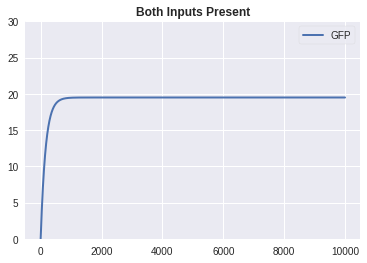

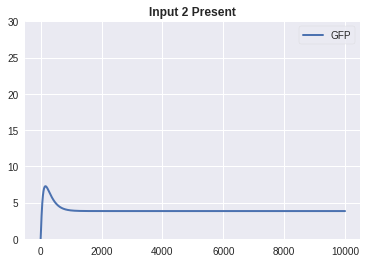

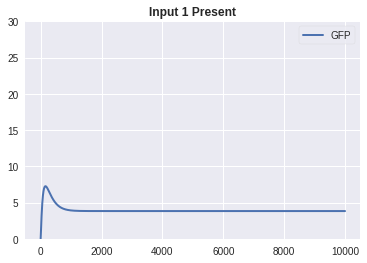

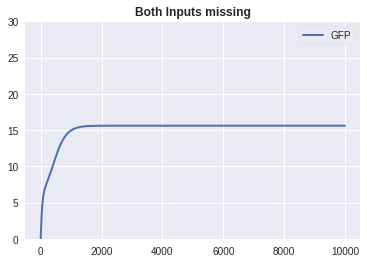

In [0]:
# XNOR GATE

connections_to_add = {1:["INPUT1", "INPUT2"], 2:["INPUT1",1], 3:[1,"INPUT2"], 4:[2,3]}
gate_types = {1:"NOR", 2:"NOR", 3:"NOR", 4:"NOR"}

XNOR_gate = add_connections("", connections_to_add, gate_types)
full_model = incomplete_model + XNOR_gate + "\n\nG4.OUTPUT is GFP \nend"

model = te.loada(full_model)
check_logic_table(model)

xnor_gate = "model XNOR_gate()\n\nspecies INPUT1, INPUT2, OUTPUT \n\n" + XNOR_gate + "G4.OUTPUT is OUTPUT\nend"

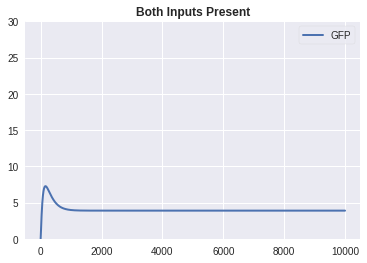

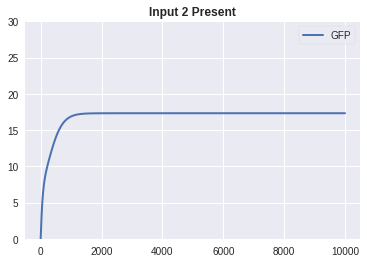

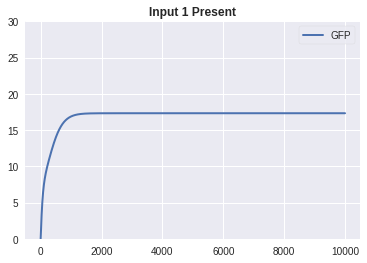

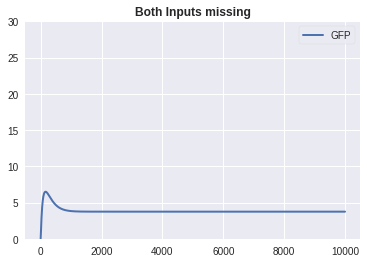

In [0]:
# XOR GATE

# Create five gates, all of which are NOR gates
# Input to gate one is INPUT1 and INPUT1
# Input to gate two is INPUT2
# Input to gate three is INPUT1 and INPUT2
# Input to gate four is output of gates one and 2
# Input to gate five is output of gates 3 and 4
connections_to_add = {1:["INPUT1", "INPUT1"], 2:["INPUT2"], 3:["INPUT1","INPUT2"], 4:[1,2], 5:[3,4]}
gate_types = {1:"NOR", 2:"NOR", 3:"NOR", 4:"NOR", 5:"NOR"}
XOR_gate = add_connections("", connections_to_add, gate_types)

full_model = incomplete_model + XOR_gate + "\n\nG5.OUTPUT is GFP \nend"

model = te.loada(full_model)
check_logic_table(model)

xor_gate = "model XOR_gate()\n\nspecies INPUT1, INPUT2, OUTPUT \n\n" + XOR_gate + "G5.OUTPUT is OUTPUT\nend"



Now that we have recreated each of the fundamental logic gates, we can try forming a more complex network! We can use the add_connections method to build arbitrarily complex networks using any gate types we desire. Furthermore, we can explore the consequences of introducing more than two initial inputs/stimuli. Also, by doing this we show that you can take any specific pathway (that relies on specific molecules designed for the task) and generalize it to create the same output using only our general gates!




In [0]:
# Applying Gates to Biological Pathway
# Violacein in Bacteria
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4297522/?fbclid=IwAR1XOwqAXI4y4mIneu9w6IARb-VaIM5N9YR7JixpOMIjXbTP45P6D97R6sE

In [0]:
modelViolacein = te.loada("""
    model NOR_gate()

      species INPUT1, INPUT2, OUTPUT;


      OUTPUT => ; b * OUTPUT
      $dummy => OUTPUT ; b * ( (v_d * (1 - L)) / (1 + (INPUT1 / k_d)^n + (INPUT2 / k_d)^n) + L*v_d)


      // Species Initializations
      INPUT1 = 0;
      INPUT2 = 0;
      OUTPUT = 0;

      // Parameter Initializations
      b = 0.006;
      v_d = 20;
      L = 0.06;
      k_d = 8.75;
      n = 2.231;

    end

    model AND_gate()

        species INPUT1, INPUT2, OUTPUT 

        G1 : NOR_gate()
        G1.INPUT1 is INPUT1


        G2 : NOR_gate()
        G2.INPUT1 is INPUT2


        G3 : NOR_gate()
        G3.INPUT1 is G1.OUTPUT
        G3.INPUT2 is G2.OUTPUT
        G3.OUTPUT is OUTPUT
    end

    model NOT_gate()

      species INPUT1, OUTPUT;

      OUTPUT => ; b * OUTPUT
      $dummy => OUTPUT ; b * (  (v_d*(1 - L)) / (1 + (INPUT1 / k_d)^n) + L*v_d)


      // Species Initializations
      INPUT1 = 0;
      OUTPUT = 0;

      // Parameter Initializations
      b = 0.006;
      v_d = 20;
      L = 0.1;
      k_d = 8.75;
      n = 2.231;

    end



    model cascade()

        const initial_input_1, initial_input_2, initial_input_3, null_element
        null_element = 0;
        initial_input_1 = 100; //dCas9 + gRNA for upregulation of vioA
        initial_input_2 = 100; //dCas9 + gRNA for upregulation of vioC
        initial_input_3 = 100; //dCas9 + gRNA for upregulation of vioD

        #Protein A produced if VioA gRNA is introduced. Second input is null
        G0 : AND_gate()
        G0.INPUT1 is initial_input_1
        G0.INPUT2 is initial_input_1
        
        #Protein B produced by Protein A. Second input is null
        G1 : AND_gate()
        G1.INPUT1 is G0.OUTPUT
        G1.INPUT2 is G0.OUTPUT

        #Protein E produced by Protein B. Second input is null
        G2 : AND_gate()
        G2.INPUT1 is G1.OUTPUT
        G2.INPUT2 is G1.OUTPUT
        
        G3 : NOT_gate()
        G3.INPUT1 is initial_input_3
        
        G4: AND_gate()
        G4.INPUT1 is G2.OUTPUT
        G4.INPUT2 is G2.OUTPUT
        
        G5 : NOT_gate()
        G5.INPUT1 is initial_input_2
        
        G6: AND_gate()
        G6.INPUT1 is G4.OUTPUT
        G6.INPUT2 is initial_input_2
        
        G7: AND_gate()
        G7.INPUT1 is G2.OUTPUT
        G7.INPUT2 is initial_input_3
        
        G8: AND_gate()
        G8.INPUT1 is G7.OUTPUT
        G8.INPUT2 is initial_input_2
        
        G9: AND_gate()
        G9.INPUT1 is G4.OUTPUT
        G9.INPUT2 is G5.OUTPUT
        
        G10: AND_gate()
        G10.INPUT1 is G9.OUTPUT
        G10.INPUT2 is G3.OUTPUT
        
        G11: AND_gate()
        G11.INPUT1 is G6.OUTPUT
        G11.INPUT2 is G3.OUTPUT
        
        G12: AND_gate()
        G12.INPUT1 is G5.OUTPUT
        G12.INPUT2 is G7.OUTPUT
        
        G10.OUTPUT is PVblue
        G11.OUTPUT is Vviolet
        G12.OUTPUT is PDVgreen
        G8.OUTPUT is DVred
        
    end

""")

NameError: ignored

In [0]:
#Expect no peaks (all steady state values low). 

modelViolacein.resetToOrigin()
modelViolacein.initial_input_1 = 0 #VioA
modelViolacein.initial_input_2 = 0 #VioC
modelViolacein.initial_input_3 = 0 #VioD
modelViolacein.simulate(0,5000,100, ["time", "PVblue", "Vviolet","PDVgreen", "DVred"])
#modelViolacein.gillespie(0,1000, ["time", "PVblue", "Vviolet","PDVgreen", "DVred"])
modelViolacein.plot(ylim=[0,20])

In [0]:
#Expect peak for PV Blue

modelViolacein.resetToOrigin()
modelViolacein.initial_input_1 = 1000 #VioA
modelViolacein.initial_input_2 = 0 #VioC
modelViolacein.initial_input_3 = 0 #VioD
modelViolacein.simulate(0,5000,100, ["time", "PVblue", "Vviolet","PDVgreen", "DVred"])
#modelViolacein.gillespie(0,1000, ["time", "PVblue", "Vviolet","PDVgreen", "DVred"])
modelViolacein.plot(ylim=[0,20])

In [0]:
#Expect peak for V Violet

modelViolacein.resetToOrigin()
modelViolacein.initial_input_1 = 1000 #VioA
modelViolacein.initial_input_2 = 1000 #VioC
modelViolacein.initial_input_3 = 0 #VioD
modelViolacein.simulate(0,5000,100, ["time", "PVblue", "Vviolet","PDVgreen", "DVred"])
#modelViolacein.gillespie(0,1000, ["time", "PVblue", "Vviolet","PDVgreen", "DVred"])
modelViolacein.plot(ylim=[0,20])

In [0]:
#Expect peak for PDV Green

modelViolacein.resetToOrigin()
modelViolacein.initial_input_1 = 1000 #VioA
modelViolacein.initial_input_2 = 0 #VioC
modelViolacein.initial_input_3 = 1000 #VioD
modelViolacein.simulate(0,5000,100, ["time", "PVblue", "Vviolet","PDVgreen", "DVred"])
#modelViolacein.gillespie(0,1000, ["time", "PVblue", "Vviolet","PDVgreen", "DVred"])
modelViolacein.plot(ylim=[0,20])

In [0]:
#Expect peak for DV Red

modelViolacein.resetToOrigin()
modelViolacein.initial_input_1 = 1000 #VioA
modelViolacein.initial_input_2 = 1000 #VioC
modelViolacein.initial_input_3 = 1000 #VioD
modelViolacein.simulate(0,5000,100, ["time", "PVblue", "Vviolet", "PDVgreen", "DVred"])
#modelViolacein.gillespie(0,1000, ["time", "PVblue", "Vviolet","PDVgreen", "DVred"])
modelViolacein.plot(ylim=[0,20])